# particleScanning
## Creating a virtual particle from a series of polar equidistant images
### Steps to virtualise a scanned particle
 - Initial image processing to find region of interest
 - Get the rotation angle from the number of images in series
 - Binarisation using Otsu thresholding
 - Volume reconstruction using extrusion of binary image series
 - Generate mesh for STL file production
 - profit??????

 ### Secondary objectives
 - Code should be of production quality, linear solutions, reproducable
 - Some error handling
 


## Initial processing of images
First, navigate to the folder where the particle images are located and generate a list of file names, find the region of interest

Loading images from /mnt/e/210113142910/
/mnt/e/210113142910/210113142910_29.png


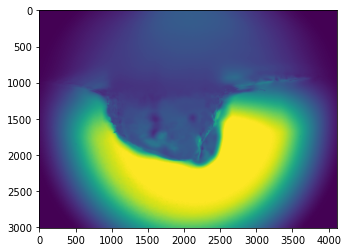

In [3]:
import os 
import sys
import glob
import matplotlib
from matplotlib import pyplot as plt
import cv2


# when script is run as file, use this to get the path used in command line input.
# for now, we'll use a discrete path for the purposes of jupyter

# pathName = sys.argv[1]
# if os.path.exists(pathName):
#     print os.path.basename(pathName)
#     # path exists

pathName = "/mnt/e/210113142910/"
if os.path.exists(pathName):
    print('Loading images from %s' % (pathName))
    imageFiles = glob.glob(pathName+'*.png')
    print(imageFiles[22])
else:
    print('Path name %s does not exist, exiting...' % (pathName))
    sys.exit(1)

img = cv2.imread(imageFiles[22])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)




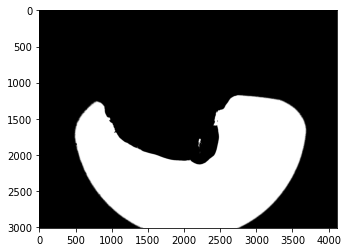

In [4]:
# Binarisation
import numpy as np

# Otsu's thresholding
# ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY)
ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

particle_thresh =  th2
plt.imshow(particle_thresh,'gray')
# plt.imshow(th3,'gray')

# Take thresholded image and increase 255 area to edges of frame
# Draw a circle around image 

# particle = img[min_rect]

In [7]:
# Find first x point to left and right of centre that is 255 and 0, match these to remove zero values 
# ...this point represents outisde of particle.
# Use new arrays to crop roi of image based on tip of particle (only common point)
import pandas as pd

midpoint = int(particle_thresh.shape[1] / 2)

left, right = np.fliplr(particle_thresh[::,0:midpoint]), particle_thresh[::,midpoint:-1]

#find 255 values
#right side
[right_occurance_of_255_row,right_occurance_of_255_column] = np.where(right==255)
right_occurance_of_255 = np.vstack(np.where(right==255)).T

#left side
[left_occurance_of_255_row,left_occurance_of_255_column] = np.where(left==255)
left_occurance_of_255 = np.vstack((left_occurance_of_255_row,left_occurance_of_255_column)).T

#invoking pandas
right_occurance_of_255 = pd.DataFrame(data=np.vstack(np.where(right==255)).T,columns=["rows","columns"]).drop_duplicates(subset="rows", keep='first')
left_occurance_of_255 = pd.DataFrame(data=left_occurance_of_255,columns=["rows","columns"])

#removing all but first values in each row - i.e. left most
# right_occurance_of_255 = right_occurance_of_255.drop_duplicates(subset="rows", keep='first')
left_occurance_of_255 = left_occurance_of_255.drop_duplicates(subset="rows", keep='first')

#find 0 values
#right side
[right_occurance_of_0_row,right_occurance_of_0_column] = np.where(right==0)
right_occurance_of_0 = np.vstack((right_occurance_of_0_row,right_occurance_of_0_column)).T

#left side
[left_occurance_of_0_row,left_occurance_of_0_column] = np.where(left==0)
left_occurance_of_0 = np.vstack((left_occurance_of_0_row,left_occurance_of_0_column)).T

#invoking pandas
right_occurance_of_0 = pd.DataFrame(data=right_occurance_of_0,columns=["rows","columns"])
left_occurance_of_0 = pd.DataFrame(data=left_occurance_of_0,columns=["rows","columns"])

#removing all but first values in each row - i.e. left most
right_occurance_of_0 = right_occurance_of_0.drop_duplicates(subset="rows", keep='first')
left_occurance_of_0 = left_occurance_of_0.drop_duplicates(subset="rows", keep='first')



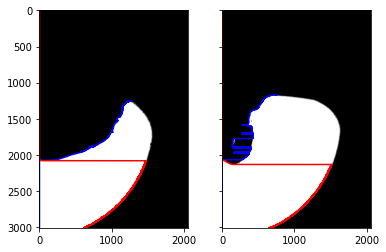

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(left,'gray')
ax1.plot(left_occurance_of_255['columns'],left_occurance_of_255['rows'],'b')
ax1.plot(left_occurance_of_0['columns'],left_occurance_of_0['rows'],'r')

ax2.imshow(right,'gray')
ax2.plot(right_occurance_of_255['columns'],right_occurance_of_255['rows'],'b')
ax2.plot(right_occurance_of_0['columns'],right_occurance_of_0['rows'],'r')

2132 2080
1167 1252
784 2816 2132


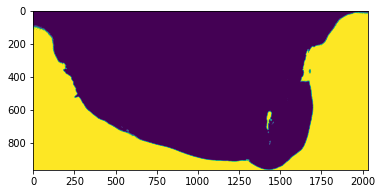

In [11]:
#Find the point where the particle surround ends and set all values outside of this range to 255 enabling canny edge detection
#set the values by cropping the particle based upon the initial binary area and the inflection point of the 255 area
outer_bound_left, outer_bound_right = (left.shape[1]-max(left_occurance_of_255['columns'])), max(right_occurance_of_255['columns'])+right.shape[1]

#find the max point at which there is a large change in occurance_of_0, this represents the tip of the particle (red line in previous frame)
change_right_occurance_of_0, change_left_occurance_of_0 = right_occurance_of_0.diff(), left_occurance_of_0.diff()

print(right_occurance_of_0.loc[change_right_occurance_of_0['columns'].idxmax(axis=0),'rows'],left_occurance_of_0.loc[change_left_occurance_of_0['columns'].idxmax(axis=0),'rows'])
outer_bound_top = max(right_occurance_of_0.loc[change_right_occurance_of_0['columns'].idxmax(axis=0),'rows'],left_occurance_of_0.loc[change_left_occurance_of_0['columns'].idxmax(axis=0),'rows'])

#find the min point of occurance_of_255 to find the point to cut the bottom of the particle
change_right_occurance_of_255, change_left_occurance_of_255 = right_occurance_of_255.diff(), left_occurance_of_255.diff()

print(right_occurance_of_255.loc[right_occurance_of_255['columns'].idxmax(axis=0),'rows'],left_occurance_of_255.loc[left_occurance_of_255['columns'].idxmax(axis=0),'rows'])
outer_bound_bottom = min(right_occurance_of_255.loc[right_occurance_of_255['columns'].idxmax(axis=0),'rows'],left_occurance_of_255.loc[left_occurance_of_255['columns'].idxmax(axis=0),'rows'])

#print cropping bounds
print(outer_bound_left,outer_bound_right,outer_bound_top)

cropped = particle_thresh[outer_bound_bottom:outer_bound_top:,outer_bound_left:outer_bound_right:]

plt.imshow(cropped)


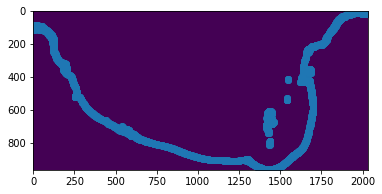

In [12]:
edges = cv2.Canny(cropped,ret2,255)

plt.imshow(edges)

indices = np.where(edges != [0])
coordinates = zip(indices[1], indices[0])

plt.scatter(*zip(*coordinates))

In [7]:
# Pull pickled data from Arrangement_Binarisation.py and continue with analysis
import pickle
import os

pathName = "/mnt/e/210113142910/"
filename = "data.pkl"
print(os.path.join(pathName,filename))

infile = open(os.path.join(pathName,filename),'rb')
BinData = pickle.load(infile)
infile.close()
print(BinData)

/mnt/e/210113142910/data.pkl
{'210113142910_0000.png': [(968, 2030), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)], '210113142910_0001.png': [(996, 2004), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)], '210113142910_0002.png': [(1019, 2128), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255